In [ ]:
import sys
import os

# Add the parent folder to facilitate imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import plotly.graph_objects as go
from Backtester.Backtester import Backtester
from Backtester.Strategies.Strategy import Strategy, StrategyOutput, StrategyOutputType, TradeInstruction

# Data

In [2]:
full_data = pd.read_csv("../Data/bitcoin_data_daily.csv", sep=";", parse_dates=["timeOpen"])

In [3]:
treated_data = full_data.loc[:,["timeOpen", "open", "high", "low", "close"]]
indexed_data = full_data.set_index("timeOpen").loc[:,["open", "high", "low", "close"]].sort_index()

In [4]:
data = pd.DataFrame({"Bitcoin": indexed_data['close']})

# Tests

In [5]:
class RSIStrat(Strategy):

    def __init__(self, number_days, buy_limit, sell_limit):
        self.__period = number_days
        self.__buy_limit = buy_limit
        self.__sell_limit = sell_limit
        self.RSIs = {"Date":[], "RSI": []}

    def initiate_strategy(self, data):
            diffs = data.iloc[-(self.__period + 1):].diff().iloc[1:]
            self.__avg_gain = diffs.where(diffs > 0, 0).mean()
            self.__avg_loss = -diffs.where(diffs < 0, 0).mean()
            self.__last_prices = data.iloc[-1]

    def generate_signal(self, date, prices):

        last_change = (prices - self.__last_prices)
        self.__avg_gain = ((self.__avg_gain*(self.__period - 1)) + last_change.clip(lower=0))/self.__period
        self.__avg_loss = ((self.__avg_loss*(self.__period - 1)) - last_change.clip(upper=0))/self.__period

        RS = self.__avg_gain/self.__avg_loss
        if any(self.__avg_loss == 0):
            RS.loc[self.__avg_loss == 0] = 100

        RSI = 100 - (100/(1+RS))
        prev_RSI = self.RSIs["RSI"][-1] if len(self.RSIs["RSI"]) else RSI
        self.RSIs["Date"].append(date)
        self.RSIs["RSI"].append(RSI)

        # We update the last price
        self.__last_prices = prices

        # For each existing ticker, we create the signals
        for ticker, curr_rsi in RSI.items():
            if curr_rsi < self.__buy_limit:
                return StrategyOutput(StrategyOutputType.SIGNAL, {ticker: TradeInstruction(1, 1/len(prices))})

            if (prev_RSI[ticker] < 50 and curr_rsi > 50) or (prev_RSI[ticker] > 50 and curr_rsi < 50):
                return StrategyOutput(StrategyOutputType.SIGNAL, {ticker: TradeInstruction(0)})

            if curr_rsi > self.__sell_limit:
                return StrategyOutput(StrategyOutputType.SIGNAL, {ticker: TradeInstruction(-1, 1/len(prices))})
        
        return StrategyOutput(StrategyOutputType.NONE, None)

In [6]:
bt = Backtester(data, 50)
strat = RSIStrat(14, 25, 75)


In [7]:
ptf_values, orders_list = bt.backtest(strat, 1000)

{}
Series([], dtype: object)
Bitcoin    42742.652837
Name: 2024-01-17 00:00:00+00:00, dtype: float64
Bitcoin    NaN
dtype: object
Fin d'un passage
{}
Series([], dtype: object)
Bitcoin    41262.058364
Name: 2024-01-18 00:00:00+00:00, dtype: float64
Bitcoin    NaN
dtype: object
Fin d'un passage
{}
Series([], dtype: object)
Bitcoin    41618.407365
Name: 2024-01-19 00:00:00+00:00, dtype: float64
Bitcoin    NaN
dtype: object
Fin d'un passage
{}
Series([], dtype: object)
Bitcoin    41665.584836
Name: 2024-01-20 00:00:00+00:00, dtype: float64
Bitcoin    NaN
dtype: object
Fin d'un passage
{}
Series([], dtype: object)
Bitcoin    41545.783514
Name: 2024-01-21 00:00:00+00:00, dtype: float64
Bitcoin    NaN
dtype: object
Fin d'un passage
{}
Series([], dtype: object)
Bitcoin    39507.368824
Name: 2024-01-22 00:00:00+00:00, dtype: float64
Bitcoin    NaN
dtype: object
Fin d'un passage
{}
Series([], dtype: object)
Bitcoin    39845.551147
Name: 2024-01-23 00:00:00+00:00, dtype: float64
Bitcoin    NaN
dt

In [8]:
orders_list

,Date,Type,Ticker,Quantity,Price
0,2024-02-12 00:00:00+00:00,Sell,Bitcoin,0.020017,49958.224219
1,2024-03-19 00:00:00+00:00,Buy,Bitcoin,0.020017,61912.773152
2,2024-11-10 00:00:00+00:00,Sell,Bitcoin,0.009453,80474.185602
3,2024-12-19 00:00:00+00:00,Buy,Bitcoin,0.009453,97490.949983


In [9]:
fig = go.Figure(data=[go.Candlestick(
    x=treated_data['timeOpen'],
    open=treated_data['open'],
    high=treated_data['high'],
    low=treated_data['low'],
    close=treated_data['close']
)])

fig.update_layout(
    title='Bitcoin Prices',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,)

for _,curr_order in orders_list.iterrows():
    y = indexed_data.loc[curr_order["Date"]]["low"] - (0.05*indexed_data.loc[curr_order["Date"]]["low"]) if curr_order["Type"] == "Buy" else indexed_data.loc[curr_order["Date"]]["high"] + (0.05*indexed_data.loc[curr_order["Date"]]["high"])
    color = "green" if curr_order["Type"] == "Buy" else "red"
    direction = "triangle-up" if curr_order["Type"] == "Buy" else "triangle-down"

    fig.add_trace(go.Scatter(
        x=[curr_order["Date"]],
        y=[y],
        mode="markers",
        marker_symbol=direction,
        marker_size = 12,
        marker_color=color,
        showlegend=False
    ))

fig.show()

<Axes: >

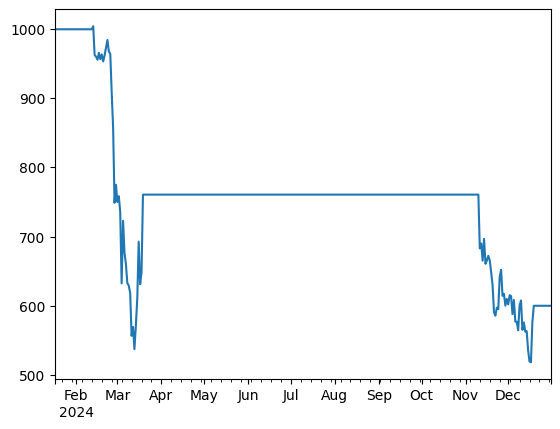

In [10]:
ptf_values.plot()